Import Libaries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import folium
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import math

Read and format data

In [2]:
df = pd.read_csv("testdata.csv")
df['DateTime'] = pd.to_datetime(df['DateTime'])
df.head()

,DateTime,Latitude,Longitude,Depth,Magnitude,MagType,NbStations,Gap,Distance,RMS,Source,EventID
0,2000-01-01 00:03:53.650,37.41667,-121.76650,5.360,1.23,Md,21,78,5,0.04,NCSN,21075021
1,2000-01-01 00:09:21.180,37.63683,-119.04967,0.098,0.95,Md,9,104,3,0.06,NCSN,21075023
2,2000-01-01 02:30:44.070,37.56633,-118.82633,2.423,1.25,Md,14,163,3,0.01,NCSN,30503920
3,2000-01-01 05:19:24.020,36.03900,-120.57733,8.695,1.19,Md,13,169,4,0.01,NCSN,21075061
4,2000-01-01 06:05:57.080,35.98967,-120.54884,4.143,1.14,Md,15,133,5,0.03,NCSN,21075067


Filtering data for magnitude >= 5

In [3]:
filtered_df = df.copy()
filtered_df = filtered_df[filtered_df['Magnitude'] >= 5]
filtered_df.head()

,DateTime,Latitude,Longitude,Depth,Magnitude,MagType,NbStations,Gap,Distance,RMS,Source,EventID
2380,2000-03-16 15:19:56.380,40.38867,-125.23850,4.803,5.7,Mw,139,228,77,0.29,NCSN,21086915
13604,2001-01-13 13:08:42.100,40.75566,-125.24450,2.243,5.4,Mw,155,233,83,0.26,NCSN,21143281
20427,2001-07-17 12:07:25.830,36.01266,-117.86633,7.158,5.2,Mw,15,177,19,0.06,NCSN,21181820
21603,2001-08-10 20:19:27.060,39.81116,-120.61667,5.011,5.2,Mw,76,111,35,0.34,NCSN,21188442
33074,2002-06-17 16:55:07.680,40.80983,-124.55200,17.195,5.2,Mw,63,225,41,0.16,NCSN,21231051


Add empty Column for Aftershock Counter

In [4]:
aftershock_data = filtered_df.copy()
for i in range(0,30):
    aftershock_data['day'+str(i)] = pd.Series([None] * len(aftershock_data))
aftershock_data['overallAftershocks'] = pd.Series([None] * len(aftershock_data))
aftershock_data.head()

,DateTime,Latitude,Longitude,Depth,Magnitude,MagType,NbStations,Gap,Distance,RMS,...,day21,day22,day23,day24,day25,day26,day27,day28,day29,overallAftershocks
2380,2000-03-16 15:19:56.380,40.38867,-125.23850,4.803,5.7,Mw,139,228,77,0.29,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13604,2001-01-13 13:08:42.100,40.75566,-125.24450,2.243,5.4,Mw,155,233,83,0.26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20427,2001-07-17 12:07:25.830,36.01266,-117.86633,7.158,5.2,Mw,15,177,19,0.06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21603,2001-08-10 20:19:27.060,39.81116,-120.61667,5.011,5.2,Mw,76,111,35,0.34,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33074,2002-06-17 16:55:07.680,40.80983,-124.55200,17.195,5.2,Mw,63,225,41,0.16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Count aftershocks after every bigger eartquake and add them as a new column

In [5]:
for event_id in filtered_df['EventID'].unique():
    event_data = filtered_df[filtered_df['EventID'] == event_id]
    
    earthquake_datetime = event_data['DateTime'].iloc[0]

    # Iterate through days after the earthquake and count aftershocks
    aftershock_counts = []
    overall_count = 0
    for i in range(0, 30):
      day = earthquake_datetime + pd.Timedelta(days=i)
      day_after = day + pd.Timedelta(days=1)
      aftershocks_after_day = df[(df['DateTime'] > day)]
      aftershocks_on_day = aftershocks_after_day[(aftershocks_after_day['DateTime'] < day_after)]
      aftershock_count = len(aftershocks_on_day)
      overall_count += aftershock_count
      daystring = "day"+str(i)
      aftershock_data.loc[aftershock_data["EventID"]== event_id,daystring] = aftershock_count
    aftershock_data.loc[aftershock_data["EventID"]== event_id,"overallAftershocks"] = overall_count

In [6]:
aftershock_data.head()

,DateTime,Latitude,Longitude,Depth,Magnitude,MagType,NbStations,Gap,Distance,RMS,...,day21,day22,day23,day24,day25,day26,day27,day28,day29,overallAftershocks
2380,2000-03-16 15:19:56.380,40.38867,-125.23850,4.803,5.7,Mw,139,228,77,0.29,...,37,36,46,43,32,32,37,37,49,965
13604,2001-01-13 13:08:42.100,40.75566,-125.24450,2.243,5.4,Mw,155,233,83,0.26,...,35,31,43,39,42,44,34,30,38,1043
20427,2001-07-17 12:07:25.830,36.01266,-117.86633,7.158,5.2,Mw,15,177,19,0.06,...,43,37,33,62,39,71,37,51,35,1454
21603,2001-08-10 20:19:27.060,39.81116,-120.61667,5.011,5.2,Mw,76,111,35,0.34,...,33,40,37,32,36,29,29,34,40,1099
33074,2002-06-17 16:55:07.680,40.80983,-124.55200,17.195,5.2,Mw,63,225,41,0.16,...,49,52,40,41,60,40,30,50,42,1243


In [7]:
aftershock_data.to_csv("result.csv")

Visualize aftershocks count

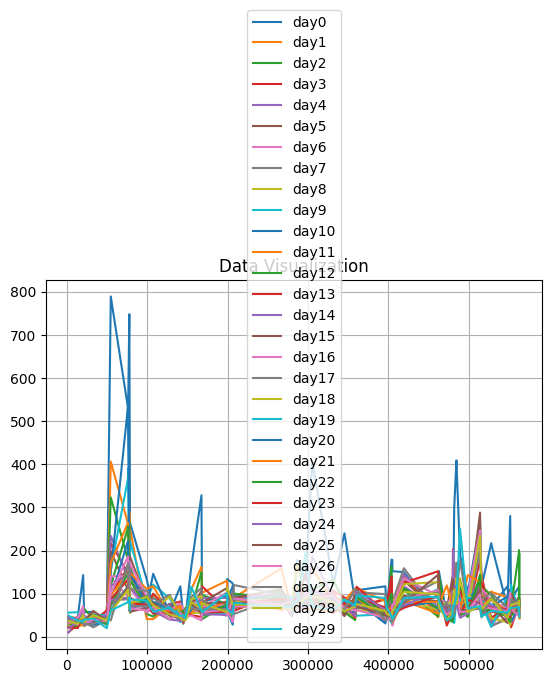

In [8]:
plt.figure()

daylist = []
for i in range(0,30):
    daylist.append("day"+str(i))

for column in daylist:
    plt.plot(aftershock_data[column], label=column)

plt.title('Data Visualization')
#plt.xticks(range(len(aftershock_data)), daylist)  # x-Achsenbeschriftung auf den Index des DataFrame setzen
plt.legend()
plt.grid(True)
plt.show()

Visualize mean of the aftershock count

<Axes: >

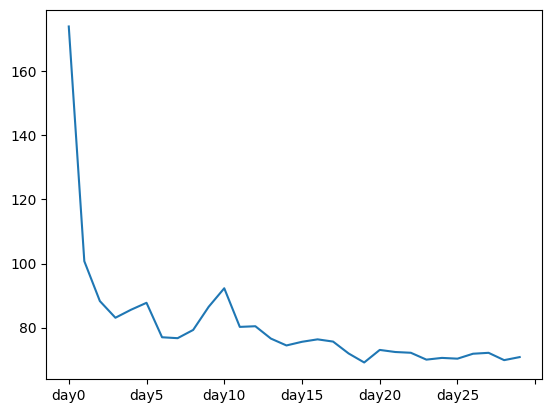

In [9]:
df_durchschnitt = aftershock_data[daylist].mean()
df_durchschnitt.plot()
#print(df_durchschnitt)

<Axes: xlabel='Magnitude', ylabel='day0'>

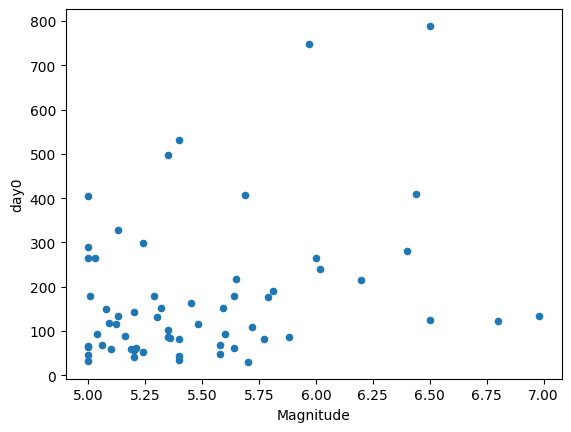

In [10]:
aftershock_data.plot(x="Magnitude",y="day0",kind="scatter")

Visualize location of Earthquakes

In [11]:
m = folium.Map(location=[aftershock_data['Latitude'].mean(), aftershock_data['Longitude'].mean()], zoom_start=6, zoom_control=False, scrollWheelZoom=False, dragging=True)
for i in range(len(aftershock_data)):
    row = aftershock_data.iloc[i]
    folium.Marker([row['Latitude'], row['Longitude']], popup=row['Magnitude']).add_to(m)
#m

Select features

In [12]:
y = aftershock_data["day0"].copy()
features = ["Latitude","Longitude","Depth","Magnitude","Gap"]
X = aftershock_data[features].copy()

In [13]:
def round_gps(coordinate):
    return round(coordinate, 1)

Preprocess

In [14]:
X_df = pd.DataFrame(data=X,columns=features)
X_df["Latitude"] = X_df["Latitude"].apply(round_gps)
X_df["Longitude"] = X_df["Longitude"].apply(round_gps)


In [16]:
num_features = ["Depth","Magnitude","Gap"]
cat_features = ["Latitude","Longitude"]
preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='mean'), num_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'),cat_features)
    ]
)

X_df = preprocessor.fit_transform(X_df)

In [17]:
y

2380       30
13604      44
20427     143
21603      57
33074      58
         ... 
551535    280
552640     87
562418    116
562481     89
563166     68
Name: day0, Length: 63, dtype: object

Train model for day0

In [18]:
model = SVR()
model.fit(X,y)

SVR()

Add data to predict

In [19]:
Longtitude = [-125.046387,-117.751465]
Latitude = [40.522151,37.709899]
Depth = [6.74,1.34]
Magnitude = [9.6,5.1]
Gap = [10,360]

data_to_predict = pd.DataFrame({"Longitude":[],"Latitude":[],"Depth":[],"Magnitude":[],"Gap":[]})

for long in Longtitude:
    for lat in Latitude:
        for dep in Depth:
            for mag in Magnitude:
                for gap in Gap:
                    new_line = [long,lat,dep,mag,gap]
                    data_to_predict.loc[len(data_to_predict)] = new_line

In [20]:
data_to_predict.head()

,Longitude,Latitude,Depth,Magnitude,Gap
0,-125.046387,40.522151,6.74,9.6,10.0
1,-125.046387,40.522151,6.74,9.6,360.0
2,-125.046387,40.522151,6.74,5.1,10.0
3,-125.046387,40.522151,6.74,5.1,360.0
4,-125.046387,40.522151,1.34,9.6,10.0


In [21]:
predictions = model.predict(data_to_predict[features])

In [22]:
data_to_predict["day0"] = predictions
data_to_predict

,Longitude,Latitude,Depth,Magnitude,Gap,day0
0,-125.046387,40.522151,6.74,9.6,10.0,132.442439
1,-125.046387,40.522151,6.74,9.6,360.0,118.813001
2,-125.046387,40.522151,6.74,5.1,10.0,132.443948
3,-125.046387,40.522151,6.74,5.1,360.0,118.809641
4,-125.046387,40.522151,1.34,9.6,10.0,132.456332
5,-125.046387,40.522151,1.34,9.6,360.0,118.832207
6,-125.046387,40.522151,1.34,5.1,10.0,132.457849
7,-125.046387,40.522151,1.34,5.1,360.0,118.828857
8,-125.046387,37.709899,6.74,9.6,10.0,132.447028
9,-125.046387,37.709899,6.74,9.6,360.0,118.815957
